<a href="https://colab.research.google.com/github/June103310110/Image_Segmentation/blob/main/PART2/create_train_ResUnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Residual Unet
source: https://arxiv.org/abs/1711.10684

- 把convolution block從兩個卷積換成包含Batch Normalization和Skip Connections的Residual convolution Block。
- 下採樣的機制取消pooling，而是在Residual convolution Block的第一個卷積層採用stride=2的參數，實現1/2的下採樣。
- 取消Unet的Crop機制。(卷積的padding設定為same)

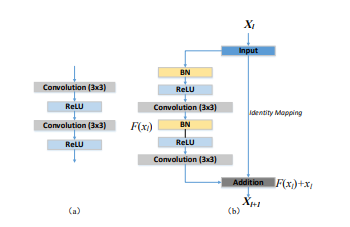


In [1]:
import torch # 1.9
import torchvision
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import cv2
import os

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu' # for debug建議使用cpu作為torch的運行背景
# device

In [12]:
# # 原始的simple Unet
# class SimpleConvBlock(nn.Module):
#     def __init__(self, in_ch, out_ch, stride=1, padding=1):
#         super().__init__()

        
#         self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size, padding=pad)
#         self.relu  = nn.ReLU()
#         self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size, padding=pad)

#     def forward(self, x):
#         return self.relu(self.conv2(self.relu(self.conv1(x))))

#### 修改版本
- 參考1: Residual Unet [source](https://arxiv.org/abs/1711.10684)
- 建議，如果Batchsize不大，可以使用Instance Normalization。讓輸出的各個feature-map更robust。

In [13]:
# 參考1: Residual Unet
class ResidualConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=2, padding='same'):
        super().__init__()
        pad_size = lambda kernel_size:(kernel_size-1)//2
        kernel_size = 3
        pad = pad_size(kernel_size) if padding=='same' else padding   
        
        self.conv_block = nn.Sequential(
          nn.BatchNorm2d(in_ch),
          nn.ReLU(),
          nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=pad),
          nn.BatchNorm2d(out_ch),
          nn.ReLU(),
          nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=pad),
          )
        self.conv_skip = nn.Sequential(
          nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=pad),
        )


    def forward(self, x):

        return self.conv_block(x) + self.conv_skip(x)

In [14]:
class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True, padding='same'):
        super().__init__()
        if bilinear:
            # normal convolutions to reduce the number of channels
            self.up = nn.Sequential(nn.Upsample(scale_factor = 2, mode = 'bilinear', align_corners = True),
                                    nn.Conv2d(in_ch, (in_ch // 2), 3, padding=1, bias=True),
                                    nn.BatchNorm2d(in_ch // 2),
                                    nn.ReLU(),)
        else:
            self.up = nn.Sequential(nn.ConvTranspose2d(in_ch, (in_ch // 2), kernel_size = 2, stride = 2),
                                    nn.BatchNorm2d(in_ch // 2),
                                    nn.ReLU(),)

        pad = 1 if (padding==True or padding=='same') else 0
        self.ResidualConvBlock = ResidualConvBlock(in_ch, out_ch, 2, padding=pad)

    def forward(self, x, enc_ftrs):
        x = self.up(x)
        enc_ftrs = self.crop(enc_ftrs, x)
        x = torch.cat([x, enc_ftrs], dim=1)
        x = self.ResidualConvBlock(x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs

In [15]:
class ResUnet(nn.Module):
    def __init__(self, out_sz, in_ch, out_ch, bilinear=True, activation=None):
#     def __init__(self, num_classes=1, channel=3, filters=[64, 128, 256, 512], activation=nn.Sigmoid()):
        super(ResUnet, self).__init__()
        if isinstance(out_sz,(int)): self.out_sz = (out_sz, out_sz)
        if isinstance(out_sz,(tuple,list)): self.out_sz = tuple(out_sz)
        
        chs = (64, 128, 256, 512, 1024)
        
        self.head = nn.Conv2d(chs[0], out_ch, 1)
        self.activation = activation
        self.out_sz = out_sz
        
        '''
        Unet with nn.ModuleList
        '''
        self.input_layer = nn.Sequential(
            nn.Conv2d(in_ch, chs[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(chs[0]),
            nn.ReLU(),
            nn.Conv2d(chs[0], chs[0], kernel_size=3, padding=1),
        )
        self.input_skip = nn.Sequential(
            nn.Conv2d(in_ch, chs[0], kernel_size=3, padding=1)
        )
        self.down_list = nn.ModuleList([ResidualConvBlock(chs[i], chs[i+1], 2, padding='same') for i in range(len(chs)-1)]) 
        chs = chs[::-1]
        self.up_list = nn.ModuleList([Up(chs[i], chs[i+1], 2, padding='same') for i in range(len(chs)-1)]) 


    def forward(self, x):
        x = self.input_layer(x) + self.input_skip(x)
        
        enc_ftrs = [x]
        for idx in range(len(self.down_list)):
            outputs = self.down_list[idx](enc_ftrs[idx])
            enc_ftrs.append(outputs)
        enc_ftrs = enc_ftrs[::-1]
        
        tmp_ftr = enc_ftrs[0] 
        for idx in range(len(self.up_list)):
            tmp_ftr = self.up_list[idx](tmp_ftr, enc_ftrs[idx+1])
        
        logits = self.head(tmp_ftr)
        
        # interpolate 
        _, _, H, W = logits.shape
        if (H,W)==self.out_sz: pass
        else:
            logits = F.interpolate(logits, self.out_sz)
        
        # add activation (not necessary)
        if self.activation:
            logits = self.activation(logits)
        
        return logits

In [16]:
if __name__ == '__main__':
    HEIGHT, WIDTH,  = (512, 512)
    net = ResUnet(HEIGHT, 3, 1, bilinear=True, activation=None)
    
    x    = torch.randn(1, 3, WIDTH, HEIGHT)#.to(device)
    y_pred = net(x)
    print(y_pred.shape)
    



torch.Size([1, 1, 512, 512])


In [17]:
import os
if __name__ == '__main__':
    if get_ipython().__class__.__name__ =='ZMQInteractiveShell':
        os.system('jupyter nbconvert ResUnet.ipynb --to python')


[NbConvertApp] Converting notebook ResUnet.ipynb to python
[NbConvertApp] Writing 6262 bytes to ResUnet.py
